# CNN training

In [1]:
import os
import re
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import PIL
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from __future__ import print_function
import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Tensorflow version 2.2.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Functions

In [3]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [4]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [5]:
def showImg(img_data):
    if type(img_data) is list:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)

In [6]:
def resizeCropImg(img_file, target_width, target_height):
    image = tf.keras.preprocessing.image.load_img(img_file)
    width, height = image.size
    left   = width*0.13
    top    = height*0.13
    right  = width*0.87
    bottom = height*0.87
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height))
    return image

In [7]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

# Processing

In [8]:
img_width, img_height = 224, 224

In [9]:
# ## For all deletions, including common and rare
# true_del_file = '/home/rt2776/cnv_espresso/images/true_del_entire_path.list'
# false_del_file = '/home/rt2776/cnv_espresso/images/false_del_entire_path.list'

In [10]:
# ## For rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del.list'

In [11]:
# ## For rare duplications
# true_dup_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup.list'
# false_dup_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup.list'

In [12]:
# ## For splited rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del_splits.list'

In [13]:
# ## For splited rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup_splits.list'

### Loading cnv image file paths to list

In [14]:
# true_list = [each_file[0] for each_file in fileToList(true_file)]
# false_list = [each_file[0] for each_file in fileToList(false_file)]
# len(true_list), len(false_list)

### Loading images from list to numpy array

In [15]:
# false_img_np = loadImgs(false_list, img_width, img_height)
# false_img_np.shape

In [16]:
# true_img_np = loadImgs(true_list, img_width, img_height)
# true_img_np.shape

### Generage labels

In [17]:
# true_label = [1 for i in range(0,len(true_img_np))]
# false_label = [0 for i in range(0,len(false_img_np))]
# print(true_label[0:5], false_label[0:5])
# print(len(true_label), len(false_label))

### Combine and shuffle true and false data

In [18]:
# combined_img = np.vstack((true_img_np, false_img_np))
# combined_label = true_label + false_label

In [19]:
# tmp = list(zip(combined_img, combined_label))
# random.shuffle(tmp)
# combined_img, combined_label = zip(*tmp)
# combined_img_np = np.asarray(combined_img)

### Backup or restore

In [20]:
# np.save('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_label', combined_label)
# np.save('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_img_np', combined_img_np)

In [21]:
# # Rare entire deletions
# project_name = 'rare_entire_del'
# combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_del_label.npy')
# combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_del_img_np.npy')

# # Rare entire duplications
# project_name = 'rare_entire_dup'
# combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_label.npy')
# combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_img_np.npy')

# rare split deletion
project_name = 'rare_split_del'
combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_del_splits_label.npy')
combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_del_splits_img_np.npy')

# # rare split duplications
# project_name = 'rare_split_dup'
# combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_label.npy')
# combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_img_np.npy')


In [22]:
combined_img_np.shape

(15838, 224, 224, 3)

## Split dataset into training(80%) and testing(20%) dataset

In [23]:
train_img, test_img, train_label, test_label = train_test_split(combined_img_np,combined_label,test_size=0.2,random_state=0)

In [24]:
train_img, val_img, train_label, val_label = train_test_split(train_img,train_label,test_size=0.25,random_state=0) # 0.25*0.8=0.2

In [25]:
train_img.shape, val_img.shape, test_img.shape

((9502, 224, 224, 3), (3168, 224, 224, 3), (3168, 224, 224, 3))

In [26]:
len(train_label), len(val_label), len(test_label)

(9502, 3168, 3168)

### Visulize training and testing dataset
- In order to check the performance in different size categories (number of windows/targets), we need to check the distribution of CNVs in training and testing set.

## Normalization

In [27]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = train_img.shape[1:]
input_shape = (nRows, nCols, nDims)

In [28]:
# Change to float datatype
train_img = train_img.astype('float32')
val_img   = val_img.astype('float32')
test_img  = test_img.astype('float32')

# Scale the data to lie between 0 to 1
train_img /= 255
val_img   /= 255
test_img  /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_label)
val_labels_one_hot   = to_categorical(val_label)
test_labels_one_hot  = to_categorical(test_label)

In [29]:
# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [30]:
#np.where(train_label==0)

0


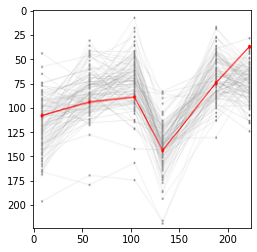

In [31]:
item = random.randint(0,len(train_label))
print(train_label[item])
showImg(train_img[item])

### Train deep nerual network model

In [32]:
model1 = createModel()
batch_size = 16
epochs = 30
#opt = keras.optimizers.Adam(learning_rate=0.01)
#model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#The learning rate. Defaults to 0.001
model1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(project_name+'_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model1.fit(train_img, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(val_img, val_labels_one_hot), callbacks=[es, mc])

## easy to exhaust the memory
# history = model1.fit(train_img, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
#                     validation_split = 0.2, callbacks=[es, mc])


Epoch 1/30
594/594 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.7401
Epoch 00001: val_accuracy improved from -inf to 0.85133, saving model to rare_entire_dup_model.h5
594/594 [==============================] - 47s 80ms/step - loss: 0.5164 - accuracy: 0.7401 - val_loss: 0.3633 - val_accuracy: 0.8513
Epoch 2/30
594/594 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8490
Epoch 00002: val_accuracy improved from 0.85133 to 0.87121, saving model to rare_entire_dup_model.h5
594/594 [==============================] - 47s 80ms/step - loss: 0.3548 - accuracy: 0.8490 - val_loss: 0.3221 - val_accuracy: 0.8712
Epoch 3/30
594/594 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8742
Epoch 00003: val_accuracy improved from 0.87121 to 0.88258, saving model to rare_entire_dup_model.h5
594/594 [==============================] - 52s 87ms/step - loss: 0.3149 - accuracy: 0.8742 - val_loss: 0.2933 - val_accuracy: 0.8826
Epoch 4/30
59

In [34]:
model1.evaluate(test_img, test_labels_one_hot)

99/99 [==============================] - 4s 41ms/step - loss: 0.2676 - accuracy: 0.8990


[0.2675588130950928, 0.8989899158477783]

Text(0.5, 1.0, 'Loss Curves')

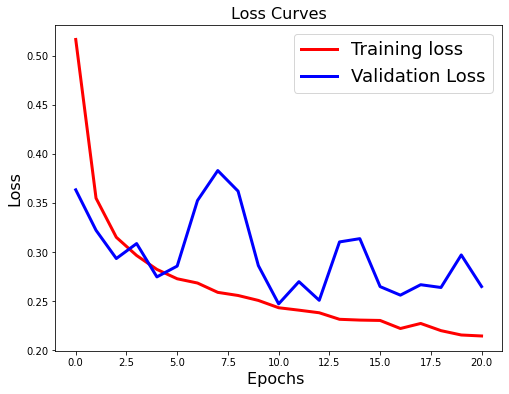

In [36]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'rare_entire_dup accuracy curves')

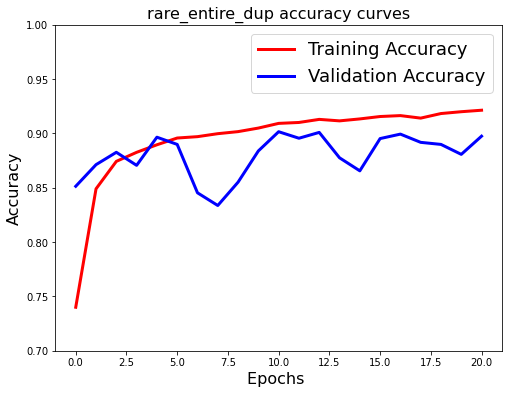

In [37]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.ylim(0.7, 1)
plt.title(project_name+' accuracy curves',fontsize=16)

### ROC curve

In [38]:
test_pred_keras = model1.predict(test_img).ravel()

In [39]:
# ravel(): Flatten the array
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels_one_hot.ravel(), test_pred_keras) 

In [40]:
auc_keras = auc(fpr_keras, tpr_keras)

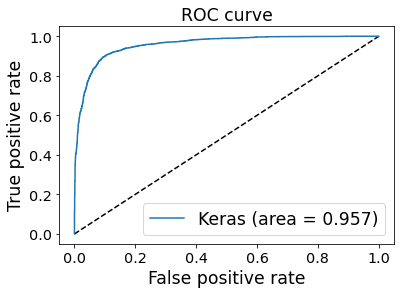

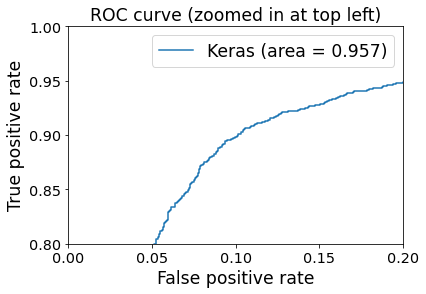

In [41]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve',fontsize="xx-large")
plt.legend(loc='best',fontsize="xx-large")
plt.tick_params(labelsize="x-large")
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.tick_params(labelsize="x-large")
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve (zoomed in at top left)',fontsize="xx-large")
plt.legend(loc='best',fontsize="xx-large")
plt.show()

In [35]:
project_name

'rare_entire_dup'

### TODO:
- Check the performance on different size categories on test data firstly and by k-fold cross validation secondly. 

## Reference:
- load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy deomo: https://zhuanlan.zhihu.com/p/51889181
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a